<h2 align=center> Toxic Comments Classification using 1D CNN with Keras</h2>

### Task 1: Import Packages and Functions

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D
from sklearn.model_selection import train_test_split
print(tf.__version__)

2.2.0


### Task 2: Load and Explore Data

In [2]:
# Load data

In [8]:
train_df = pd.read_csv('train.csv').fillna(' ')
train_df.sample(10, random_state=1)
# train_df.shape

,comment_text,toxic
24915,"YOU ARE A FAT, GEEKY PRICK WHO HAS NOTHING TO ...",1
75819,Agent X2: Basically thanks - with a 'little' m...,0
53891,Why are my posts being deleted? \n\nI have tri...,0
154159,"""\n\n Controlled Demolitions and Common Sense ...",0
13040,I do not understand your reply. //Blaxthos ( ...,0
123190,Is this the bizarro world? Removing content is...,0
33626,"Well, WP:RS says that articles should use reli...",0
1150,Oh hear me go someone removes all my pages i g...,0
48633,can't believe this article was deleted\nI'm su...,0
42817,"""\n\n Comments on GamerGate Workshop page \n\n...",0


In [4]:
x = train_df['comment_text'].values
print(x)

["Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"
 "D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)"
 "Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info."
 ...
 'Spitzer \n\nUmm, theres no actual article for prostitution ring.  - Crunch Captain.'
 'And it looks like it was actually you who put on the speedy to have the first version deleted now that I look at it.'
 '"\nAnd ... I really don\'t think you understand.  I came here and my idea was bad right away.  What kind of community goes ""you have bad ideas"" go away, instead o

In [9]:
# View few toxic comments
train_df[train_df['toxic'] == 1]

,comment_text,toxic
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
12,Hey... what is it..\n@ | talk .\nWhat is it......,1
16,"Bye! \n\nDon't look, come or think of comming ...",1
42,You are gay or antisemmitian? \n\nArchangel WH...,1
43,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1
...,...,...
159494,"""\n\n our previous conversation \n\nyou fuckin...",1
159514,YOU ARE A MISCHIEVIOUS PUBIC HAIR,1
159541,Your absurd edits \n\nYour absurd edits on gre...,1
159546,"""\n\nHey listen don't you ever!!!! Delete my e...",1


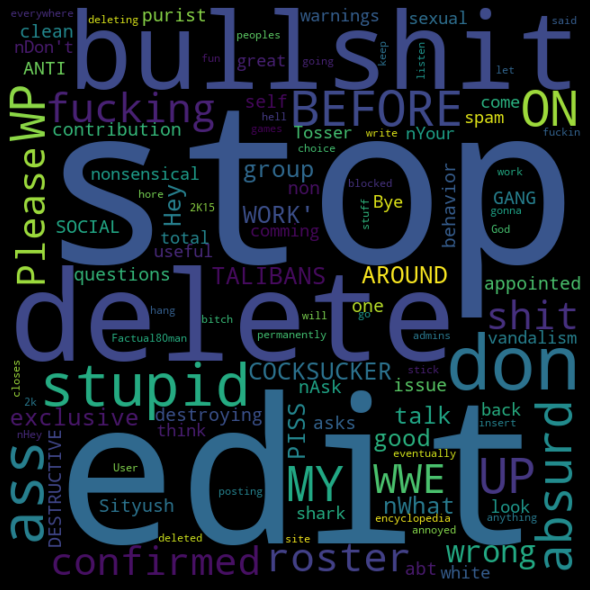

In [11]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
comments = train_df['comment_text'].loc[train_df['toxic']==1].values
wordcloud = WordCloud(
    width = 640,
    height = 640,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(comments))
fig = plt.figure(
    figsize = (12, 8),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [13]:
y = train_df['toxic'].values
print(y)

[0 0 0 ... 0 0 0]


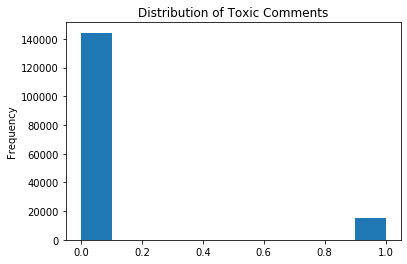

In [14]:
# Plot frequency of toxic comments
train_df['toxic'].plot(kind='hist', title='Distribution of Toxic Comments')

In [15]:
train_df['toxic'].value_counts()

0    144277
1     15294
Name: toxic, dtype: int64

### Task 3: Data Prep — Tokenize and Pad Text Data

In [21]:
max_features = 20000 # keep most frequent words aka 20000 words
max_text_length = 400

In [22]:
x_tokenizer = text.Tokenizer(max_features)
x_tokenizer.fit_on_texts(list(x))
x_tokenized = x_tokenizer.texts_to_sequences(x)
x_train_val = sequence.pad_sequences(x_tokenized, maxlen=max_text_length)

### Task 4: Prepare Embedding Matrix with Pre-trained GloVe Embeddings

In [23]:
#!wget http://nlp.stanford.edu/data/glove.6B.zip
#!unzip -q glove.6B.zip
#map words to numpy vector representation aka embeddings
embedding_dim = 100
embeddings_index = dict()
f = open('glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print(f'found {len(embeddings_index)} word vectors')

found 400000 word vectors


In [26]:
embedding_matrix = np.zeros((max_features, embedding_dim))
for word, index in x_tokenizer.word_index.items():
    if index > max_features - 1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector
    

### Task 5: Create the Embedding Layer

In [27]:
model = Sequential()
model.add(Embedding(max_features, 
                    embedding_dim,
                   embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                   trainable=False))
model.add(Dropout(0.2))

### Task 6: Build the Model

In [28]:
filters = 250
kernel_size = 3
hidden_dims = 250

In [29]:
model.add(Conv1D(filters,
                 kernel_size,
                padding='valid'))
model.add(MaxPooling1D())
model.add(Conv1D(filters, 5, padding='valid', activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(hidden_dims, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         2000000   
_________________________________________________________________
dropout (Dropout)            (None, None, 100)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 250)         75250     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 250)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 250)         312750    
_________________________________________________________________
global_max_pooling1d (Global (None, 250)               0         
_________________________________________________________________
dense (Dense)                (None, 250)               6

In [37]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

### Task 7: Train Model

In [38]:
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y, test_size=0.15, random_state=1, stratify=y)

In [39]:
%%time
batch_size=32
epochs=5

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.78 µs


In [40]:
%%time
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val, y_val))

Epoch 1/5
4239/4239 [==============================] - 89s 21ms/step - loss: 0.1544 - accuracy: 0.9441 - val_loss: 0.1552 - val_accuracy: 0.9481
Epoch 2/5
4239/4239 [==============================] - 88s 21ms/step - loss: 0.1334 - accuracy: 0.9505 - val_loss: 0.1211 - val_accuracy: 0.9530
Epoch 3/5
4239/4239 [==============================] - 86s 20ms/step - loss: 0.1245 - accuracy: 0.9529 - val_loss: 0.1184 - val_accuracy: 0.9562
Epoch 4/5
4239/4239 [==============================] - 85s 20ms/step - loss: 0.1173 - accuracy: 0.9558 - val_loss: 0.1151 - val_accuracy: 0.9572
Epoch 5/5
4239/4239 [==============================] - 84s 20ms/step - loss: 0.1123 - accuracy: 0.9574 - val_loss: 0.1147 - val_accuracy: 0.9581
CPU times: user 5min 39s, sys: 1min 6s, total: 6min 46s
Wall time: 8min 20s


### Task 8: Evaluate Model

In [42]:
# model.save('model.h5')
# import pickle
# with open('tokenizer.pkl', 'wb') as f:
#     pickle.dump(x_tokenizer, f)

In [43]:
test_df = pd.read_csv('test.csv')
x_test = test_df['comment_text'].values

In [44]:
x_test_tokenized = x_tokenizer.texts_to_sequences(x_test)

In [45]:
x_testing = sequence.pad_sequences(x_test_tokenized, maxlen=max_text_length)

In [46]:
y_testing = model.predict(x_testing, verbose=1, batch_size=32)

4787/4787 [==============================] - 37s 8ms/step


In [47]:
y_testing[0]

array([0.97983253], dtype=float32)

In [49]:
test_df['Toxic'] = ['not toxic' if x<.5 else 'toxic' for x in y_testing]

In [50]:
test_df.sample(10)

,comment_text,Toxic
8749,and by the way you all stink!!,not toxic
44083,""" \n :::::::Hm? Either your reference is lost ...",not toxic
90865,F*CK you JON GILLIBRAND,toxic
57727,:What's really sad is that I already had the (...,not toxic
47011,""" \n\n ==Speedy deletion of S.A. Wickremasingh...",not toxic
118325,""" \n\n ::::Gah, I'm a moron, not noticing this...",not toxic
143522,""" \n\n Wikilawyering WP:WL, is not editting. ...",not toxic
101634,""" \n\n == Awwww c'mon == \n\n What's the deal ...",not toxic
96019,""" \n\n ::I rewrote the section to show both po...",not toxic
22225,really appropriate for me to suck and lick. ),toxic
